# Simulation of noisy mutual inhibition
*Nhat Le, October 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def thresh_tanh(activity):
    '''Activation function for a neuron'''
    return 1 + np.tanh(activity)

def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def update_u(u, v, c1, dt):
    activation = u - (c1 * v) * dt
    #print(activation)
    return thresh_tanh(activation)

def update_v(u, v, c2, dt):
    activation = v - (c2 * u) * dt
    return thresh_tanh(activation)

def simulate_u_v(u_init, v_init, c1, c2, dt, niter):
    u_lst = []
    v_lst = []
    u = u_init
    v = v_init
    for i in range(niter):
        u = update_u(u, v, c1, dt)
        u_lst.append(u)
        v = update_v(u, v, c2, dt)
        v_lst.append(v)
    return u_lst, v_lst

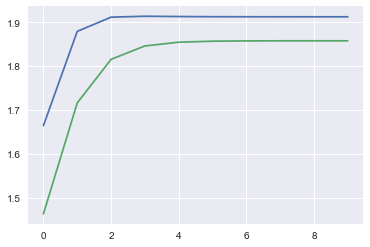

In [4]:
u1, v1 = simulate_u_v(1, 1, c1=2, c2=3, dt=0.1, niter=10)
plt.plot(u1)
plt.plot(v1);